In [1]:
from keras.applications import inception_v3
import keras.backend as K

Using TensorFlow backend.


In [2]:
K.set_learning_phase(0) #Disable any learning operation

W0816 17:42:24.307371 140266185230208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:153: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [3]:
model = inception_v3.InceptionV3(weights = 'imagenet', include_top = False) #Downloading Pre-Trained Model

W0816 17:42:24.334350 140266185230208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0816 17:42:24.340372 140266185230208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0816 17:42:24.368393 140266185230208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0816 17:42:24.369702 140266185230208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0816 17:42:24.403267 140266185230208 depre

In [4]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
layer_contributions = {'mixed2':0.2, 'mixed3':3., 'mixed4':2., 'mixed5': 1.5}

In [0]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [7]:
print(layer_dict)

{'input_1': <keras.engine.input_layer.InputLayer object at 0x7f92035e6a20>, 'conv2d_1': <keras.layers.convolutional.Conv2D object at 0x7f92035e6d30>, 'batch_normalization_1': <keras.layers.normalization.BatchNormalization object at 0x7f92035e6be0>, 'activation_1': <keras.layers.core.Activation object at 0x7f92035e6e48>, 'conv2d_2': <keras.layers.convolutional.Conv2D object at 0x7f92210dccf8>, 'batch_normalization_2': <keras.layers.normalization.BatchNormalization object at 0x7f91fe5821d0>, 'activation_2': <keras.layers.core.Activation object at 0x7f91fe4d2f28>, 'conv2d_3': <keras.layers.convolutional.Conv2D object at 0x7f91fe491d68>, 'batch_normalization_3': <keras.layers.normalization.BatchNormalization object at 0x7f91fe4abd68>, 'activation_3': <keras.layers.core.Activation object at 0x7f91fe44e240>, 'max_pooling2d_1': <keras.layers.pooling.MaxPooling2D object at 0x7f91fe3cab70>, 'conv2d_4': <keras.layers.convolutional.Conv2D object at 0x7f91fe3ca240>, 'batch_normalization_4': <keras

In [8]:
loss = K.variable(0.)
for layer_name in layer_contributions:
  coeff = layer_contributions[layer_name]
  activation = layer_dict[layer_name].output
  scaling = K.prod(K.cast(K.shape(activation), 'float32'))
  loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

W0816 17:42:37.806562 140266185230208 variables.py:2429] Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.


In [0]:
dream = model.input
grads = K.gradients(loss, dream)[0]
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)
def eval_loss_and_grads(x):
  outputs = fetch_loss_and_grads([x])
  loss_values = outputs[0]
  grads_values = outputs[1]
  return loss_values, grads_values
def gradient_ascent(x, iterations, step, max_loss = None):
  for i in range(iterations):
    loss_value, grads_value = eval_loss_and_grads(x)
    if max_loss is not None and loss_value > max_loss:
      break
    print('Loss value at ', i, 'is', loss_value)
    x += step * grads_value
  return x  

In [10]:
!pip install -U scipy==1.2.0

Requirement already up-to-date: scipy==1.2.0 in /usr/local/lib/python3.6/dist-packages (1.2.0)


In [0]:
import numpy as np
import scipy
from keras.preprocessing import image
step = 0.01
octave_scale = 1.4
iterations = 20
max_loss = 10.
base_image_path = '/content/tumblr_p9w64oRMcs1vkwwrfo1_540.jpg'
def preprocess_image(image_path):
  img = image.load_img(image_path)
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  img = inception_v3.preprocess_input(img)
  return img
img = preprocess_image(base_image_path)

In [12]:
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
print(successive_shapes)

[(810, 534)]


In [0]:
num_octaves = 3
for i in range(1, num_octaves):
  shape = tuple([dim / (octave_scale ** i) for dim in original_shape])
  successive_shapes.append(shape)

In [14]:
print(successive_shapes)

[(810, 534), (578.5714285714286, 381.42857142857144), (413.26530612244903, 272.44897959183675)]


In [0]:
successive_shapes = successive_shapes[::-1]

In [16]:
print(successive_shapes)

[(413.26530612244903, 272.44897959183675), (578.5714285714286, 381.42857142857144), (810, 534)]


In [0]:
def resize_img(img, size):
  img = np.copy(img)
  factors = (1,float(size[0]) / img.shape[1],float(size[1]) / img.shape[2],1)
  return scipy.ndimage.zoom(img, factors, order=1)
def deprocess_image(x):
  if K.image_data_format() == 'channels_first':
    x = x.reshape((3, x.shape[2], x.shape[3]))
    x = x.transpose((1, 2, 0))
  else:
    x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
  return x
def save_img(img, fname):
  pil_img = deprocess_image(np.copy(img))
  scipy.misc.imsave(fname, pil_img)

In [18]:
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])
for shape in successive_shapes:
  img = resize_img(img, shape)
  img = gradient_ascent(img, iterations = iterations, step = step, max_loss = max_loss)
  upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
  same_size_original = resize_img(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img
  img += lost_detail
  save_img(img, fname='dream_at_scale_' + str(shape) + '.png')
save_img(img, fname='final_dream.png')

Loss value at  0 is 1.9793973
Loss value at  1 is 2.2953296
Loss value at  2 is 3.0164642
Loss value at  3 is 3.653176
Loss value at  4 is 4.3312654
Loss value at  5 is 5.034578
Loss value at  6 is 5.6843605
Loss value at  7 is 6.319764
Loss value at  8 is 6.9320016
Loss value at  9 is 7.545097
Loss value at  10 is 8.1294365
Loss value at  11 is 8.703976
Loss value at  12 is 9.252948
Loss value at  13 is 9.81717


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/usr/local/lib/python3.6/dist-packages/scipy/ndimage/interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Loss value at  0 is 3.1625464
Loss value at  1 is 4.467908
Loss value at  2 is 5.5801315
Loss value at  3 is 6.521241
Loss value at  4 is 7.4073095
Loss value at  5 is 8.188454
Loss value at  6 is 8.961825
Loss value at  7 is 9.683252
Loss value at  0 is 3.2540114
Loss value at  1 is 4.511742
Loss value at  2 is 5.60428
Loss value at  3 is 6.5886846
Loss value at  4 is 7.5295324
Loss value at  5 is 8.404192
Loss value at  6 is 9.242391


In [0]:
import matplotlib.pyplot as plt

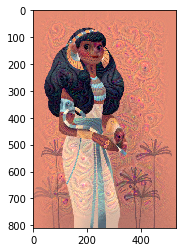

In [30]:
original_path_load = image.load_img('/content/tumblr_p9w64oRMcs1vkwwrfo1_540.jpg')
original_path_load = np.expand_dims(original_path_load, axis=0)
imgplot = plt.imshow(original_path_load[0])

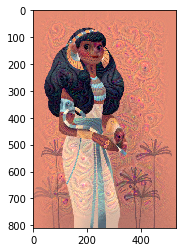

In [34]:
dream_path_load = image.load_img('/content/final_dream.png')
dream_path_load = np.expand_dims(dream_path_load, axis=0)
dreamplot = plt.imshow(dream_path_load[0])